# Mod 3 Final Project

## Student Info

- Name: 
- Cohort: 
- Instructor:


## Instructions:

- Open and read the project assignment and guidelines in `MOD_PROJECT_README.ipynb`
- Review the hypothesis testing workflow found in this repo's `README.md` and inside `hypothesis_testing_workflow.ipynb` (also at the bottom of the `MOD_PROJECT_README.ipynb`)

- 3 functions from study group/learn.co lessons have been provided inside `functions.py`
    - `Cohen_d`, `find_outliers_IQR`,`find_outliers_Z`

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

# PROJECT

In [37]:
!pip install -U fsds_100719
from fsds_100719.imports import *

import pandas as pd

Requirement already up-to-date: fsds_100719 in /anaconda3/envs/learn-env/lib/python3.6/site-packages (0.7.17)


In [38]:
# import functions as fn
# help(fn)
from functions import find_outliers_IQR,find_outliers_Z,prep_data_for_tukeys

In [39]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

In [40]:
## To see all tables
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


# Hypothesis 1

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

- $H_0$:
- $H_A$:

In [41]:
data = cur.execute("""SELECT * FROM OrderDetail""").fetchall()
cur.description

(('Id', None, None, None, None, None, None),
 ('OrderId', None, None, None, None, None, None),
 ('ProductId', None, None, None, None, None, None),
 ('UnitPrice', None, None, None, None, None, None),
 ('Quantity', None, None, None, None, None, None),
 ('Discount', None, None, None, None, None, None))

In [42]:
df = pd.DataFrame(data, columns=[x[0] for x in cur.description])
df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [43]:
from scipy import stats

In [44]:
def find_outliers(X):
    z_scores = np.abs(stats.zscore(X))
    idx_outs =  z_scores>3
    if isinstance(X,pd.Series):
        idx_outs = pd.Series(idx_outs,index=X.index)
    return idx_outs

In [45]:
grps = df.groupby('Discount').groups
for group_name,idx in grps.items():
    grps[group_name] = df.loc[idx]['Quantity'].copy()
# grps[0.0]

In [52]:
grps_clean ={}
for discount,data in grps.items():
    
    grp_name = f"{str(int(round(discount*100,0)))}%"
   
    idx_outs = find_outliers(data)
    clean_data = data[~idx_outs]#.rename(grp_name)
    
    if len(clean_data)>3:
        grps_clean[grp_name]=clean_data
    else:
        print(f"Group {discount} has too few n to include (n={len(clean_data)})")

Group 0.01 has too few n to include (n=1)
Group 0.02 has too few n to include (n=2)
Group 0.03 has too few n to include (n=3)
Group 0.04 has too few n to include (n=1)
Group 0.06 has too few n to include (n=1)


In [53]:
grps_clean.values()

dict_values([0       12
1       10
2        5
3        9
4       40
        ..
2147     2
2148     2
2151     1
2153     4
2154     2
Name: Quantity, Length: 1297, dtype: int64, 8        6
9       15
11      40
12      25
51      12
        ..
2116    10
2123    14
2134     1
2137     2
2144     2
Name: Quantity, Length: 182, dtype: int64, 107     10
108      3
115     20
116     24
117      2
        ..
2095    30
2096    77
2098    25
2099     4
2135     2
Name: Quantity, Length: 170, dtype: int64, 6       35
7       15
17      15
18      21
48      25
        ..
2112    20
2113    30
2124    10
2125    30
2126     2
Name: Quantity, Length: 155, dtype: int64, 29      50
30      65
31       6
40      12
99      45
        ..
2069    35
2071    25
2091    10
2092    12
2130    24
Name: Quantity, Length: 159, dtype: int64, 34      16
36      15
37      21
43      60
45      60
        ..
2101     4
2102    20
2127    20
2128    20
2129    10
Name: Quantity, Length: 151, dtype: int64])

In [64]:
def dict2df(grps_clean, colname_grp='Group', colname_data='Data'):
    df_list=[]
    for discount, grp_df in grps_clean.items():
        grp_df = grp_df.to_frame()
        grp_df['Group'] = discount
        df_list.append(grp_df)

    df_clean = pd.concat(df_list,axis=0)
    df_clean.columns=[colname_data,colname_grp]
    return df_clean[[colname_grp,colname_data]]

In [66]:
df_clean = dict2df(grps_clean,'Discount','Quantity')

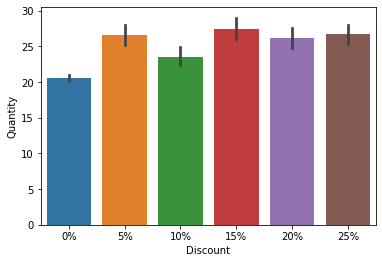

In [69]:
sns.barplot(data=df_clean,x='Discount',y='Quantity',ci=68)

In [75]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Quantity ~ C(Discount)'
model = ols(formula,df_clean).fit()

table= sm.stats.anova_lm(model).round(3)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),5.0,16749.425,3349.885,12.98,0.0
Residual,2108.0,544049.770,258.088,NaN,NaN


In [80]:
grouper.get_group('0%')

,Discount,Quantity
0,0%,12
1,0%,10
2,0%,5
3,0%,9
4,0%,40
...,...,...
2147,0%,2
2148,0%,2
2151,0%,1
2153,0%,4


In [89]:
grouper = df_clean.groupby('Discount')
for grp_name in grouper.groups:
    data = grouper.get_group(grp_name)['Quantity']
    
    val,p = stats.normaltest(data) 
    print(f"For group {grp_name} (n={len(data)}), normality test stat = {round(val,3)}, p-val={round(p,4)} \n")

For group 0% (n=1297), normality test stat = 189.44, p-val=0.0 

For group 10% (n=170), normality test stat = 39.408, p-val=0.0 

For group 15% (n=155), normality test stat = 29.69, p-val=0.0 

For group 20% (n=159), normality test stat = 15.269, p-val=0.0005 

For group 25% (n=151), normality test stat = 13.364, p-val=0.0013 

For group 5% (n=182), normality test stat = 34.143, p-val=0.0 



In [108]:
def color_sig(val):
    color = 'green' if val < .05 else 'black'
    return 'color: %s' % color

In [114]:
def test_normality(df_clean, style=True):
    res = [['Group','n','Normality Stat','p-value']]

    grouper = df_clean.groupby('Discount')
    for grp_name in grouper.groups:
        data = grouper.get_group(grp_name)['Quantity']

        val,p = stats.normaltest(data) 
        res.append([grp_name, len(data), val, p])
    res_df = pd.DataFrame(res[1:],columns=res[0]).round(4)
    
    if style:
        display(res_df.style.applymap(color_sig,subset=['p-value']))
    else:
        return res_df



test_normality(df_clean)


,Group,n,Normality Stat,p-value
0,0%,1297,189.44,0
1,10%,170,39.4078,0
2,15%,155,29.6898,0
3,20%,159,15.2686,0.0005
4,25%,151,13.3644,0.0013
5,5%,182,34.143,0


In [118]:
## Check assumption of equal variance
clean_data = list(grps_clean.values())
stats.levene(*clean_data)

LeveneResult(statistic=4.7429850894071715, pvalue=0.0002591859866634427)

In [121]:
val, p = stats.kruskal(*clean_data)
print(f"Kruskal Wallis H-Test Result = {round(val,3)}, p ={round(p,4)}")

Kruskal Wallis H-Test Result = 53.651, p =0.0


> "A Kruskal-Wallis H test showed that there was a statistically significant difference in pain score between the different drug treatments, χ2(2) = 8.520, p = 0.014, with a mean rank pain score of 35.33 for Drug A, 34.83 for Drug B and 21.35 for Drug C." - *[LAERD Statistics](https://statistics.laerd.com/spss-tutorials/kruskal-wallis-h-test-using-spss-statistics.php)*

In [126]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(df_clean['Quantity'], df_clean['Discount'])
result = mc.tukeyhsd()
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0%,10%,2.9654,0.2098,-0.7723,6.7031,False
0%,15%,6.9176,0.001,3.0233,10.8119,True
0%,20%,5.6293,0.001,1.7791,9.4796,True
0%,25%,6.1416,0.001,2.2016,10.0817,True
0%,5%,6.0639,0.001,2.4368,9.691,True
10%,15%,3.9522,0.2311,-1.1368,9.0412,False
10%,20%,2.6639,0.6409,-2.3915,7.7193,False
10%,25%,3.1762,0.4872,-1.9479,8.3004,False
10%,5%,3.0985,0.4621,-1.789,7.9861,False
15%,20%,-1.2883,0.9,-6.4605,3.884,False


In [134]:
df_tukey = pd.DataFrame(result._results_table.data[1:],
                        columns=result._results_table.data[0])
df_tukey.style.applymap(color_sig,subset=['p-adj'])

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0%,10%,2.9654,0.2098,-0.7723,6.7031,False
1,0%,15%,6.9176,0.001,3.0233,10.8119,True
2,0%,20%,5.6293,0.001,1.7791,9.4796,True
3,0%,25%,6.1416,0.001,2.2016,10.0817,True
4,0%,5%,6.0639,0.001,2.4368,9.691,True
5,10%,15%,3.9522,0.2311,-1.1368,9.0412,False
6,10%,20%,2.6639,0.6409,-2.3915,7.7193,False
7,10%,25%,3.1762,0.4872,-1.9479,8.3004,False
8,10%,5%,3.0985,0.4621,-1.789,7.9861,False
9,15%,20%,-1.2883,0.9,-6.4605,3.884,False


In [91]:
formula = "Quantity ~ C(Discount)"#"*UnitPrice"
lm = ols(formula,df).fit()

table = sm.stats.anova_lm(lm)#typ=2)

table.round(3)

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),10.0,21258.404,2125.840,6.012,0.0
Residual,2144.0,758141.233,353.611,NaN,NaN


In [74]:
# formula = "Quantity ~ C(Discount) +UnitPrice + C(Discount):UnitPrice"
# lm = ols(formula,df).fit()

# table = sm.stats.anova_lm(lm)#typ=2)

# table.round(3)

In [15]:
formula = "Quantity ~ C(Discount)*UnitPrice"
lm = ols(formula,df).fit()

table = sm.stats.anova_lm(lm)#typ=2)

table.round(3)

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),10.0,21258.404,2125.840,6.005,0.000
UnitPrice,1.0,39.419,39.419,0.111,0.739
C(Discount):UnitPrice,10.0,2532.639,253.264,0.715,0.711
Residual,2136.0,756157.134,354.006,NaN,NaN


In [16]:
print(f"Overall model F({lm.df_model:.0f}, {lm.df_resid:.0f}) = {lm.fvalue:.3f}, p={lm.f_pvalue:.4f}")
display(table.round(3))

Overall model F(18, 2136) = 3.648, p=0.0000


,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),10.0,21258.404,2125.840,6.005,0.000
UnitPrice,1.0,39.419,39.419,0.111,0.739
C(Discount):UnitPrice,10.0,2532.639,253.264,0.715,0.711
Residual,2136.0,756157.134,354.006,NaN,NaN


In [17]:
# lm.summary()

## Discounts by Country

In [18]:
# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as stats

In [19]:
query = "SELECT * FROM OrderDetail"
df_od = pd.DataFrame(cur.execute(query).fetchall(),
                    columns =[x[0] for x in cur.description])
df_od

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [20]:
query = "SELECT * FROM 'Order'"
df_o = pd.DataFrame(cur.execute(query).fetchall(),
                    columns =[x[0] for x in cur.description])
df_o.rename({'Id':'OrderId'},axis=1,inplace=True)
df_o

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,2014-05-05,2014-06-02,None,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,Central America,05033,Mexico
826,11074,SIMOB,7,2014-05-06,2014-06-03,None,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,Northern Europe,1734,Denmark
827,11075,RICSU,8,2014-05-06,2014-06-03,None,2,6.19,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
828,11076,BONAP,4,2014-05-06,2014-06-03,None,2,38.28,Bon app',"12, rue des Bouchers",Marseille,Western Europe,13008,France


In [21]:
df = pd.merge(df_od,df_o,on='OrderId')
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [22]:
df.groupby('')

KeyError: ''

In [ ]:
df.isna().sum()

In [ ]:
formula = "Quantity~ C(Discount)*C(ShipRegion)"
model = ols(formula,df).fit()
table = sm.stats.anova_lm(model)#typ=2)
table.round(3)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


In [ ]:
mc = MultiComparison(df['Score'], data['Archer'])
result = mc.tukeyhsd()

In [ ]:
capt = f"Overall model F({model.df_model:.0f}, {model.df_resid:.0f}) = {model.fvalue:.3f}, p={model.f_pvalue:.4f}"
sm.stats.anova_lm(model).round(3).style.set_caption(capt)